In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [2]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [3]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]

data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [4]:
max_prediction_length = 6
max_encoder_length = 24

training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [5]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=4)

In [6]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

293.0088195800781

In [7]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=2,
    gpus=0,
    weights_summary=None,
    enable_model_summary=False,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

c:\Users\zyf13\AppData\Local\Programs\Python\Python37\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:172: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


In [8]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Epoch 1: 100%|██████████| 31/31 [00:24<00:00,  1.24it/s, loss=72.9, v_num=4, train_loss_step=73.90, val_loss=104.0, train_loss_epoch=78.30]


In [9]:
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=2,
    max_epochs=2,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-11-17 16:18:34,657] A new study created in memory with name: no-name-b3099f9e-2b46-4907-9160-ac6787185a3f
c:\Users\zyf13\AppData\Local\Programs\Python\Python37\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:172: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2022-11-17 16:19:39,580] Trial 0 finished with value: 108.40120697021484 and parameters: {'gradient_clip_val': 0.04476059152287539, 'hidden_size': 64, 'dropout': 0.1602323196660353, 'hidden_continuous_size': 11, 'attention_head_size': 4, 'learning_rate': 0.0036723088434188512}. Best is trial 0 w

{'gradient_clip_val': 0.7146013082310766, 'hidden_size': 70, 'dropout': 0.13557709869274656, 'hidden_continuous_size': 10, 'attention_head_size': 1, 'learning_rate': 0.013493501456599341}


In [10]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [12]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(390.6463)

In [13]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

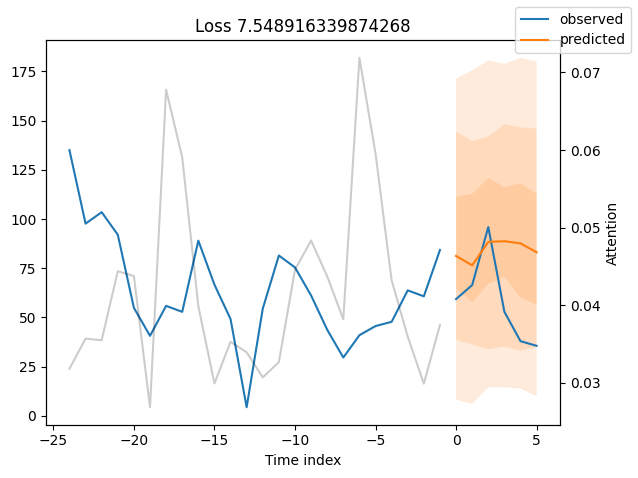

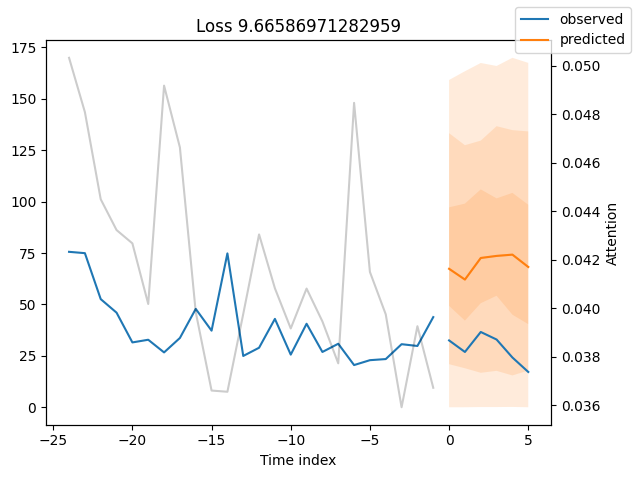

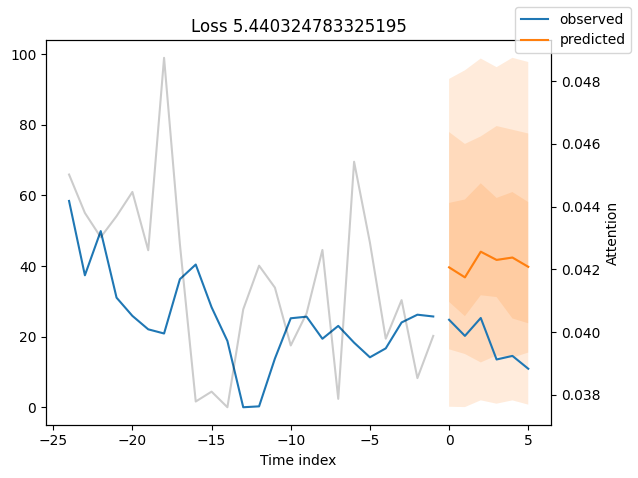

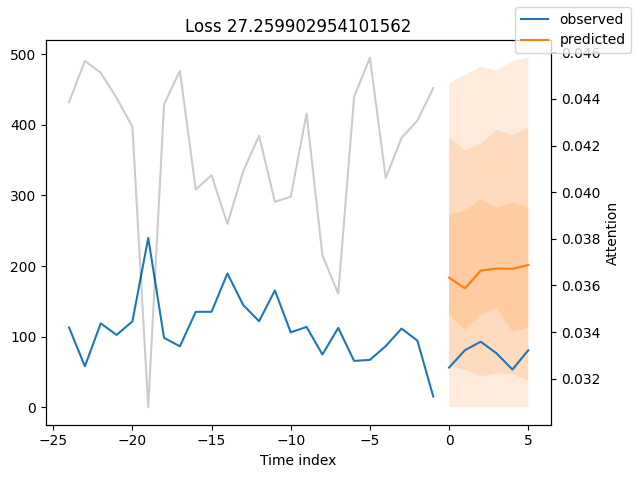

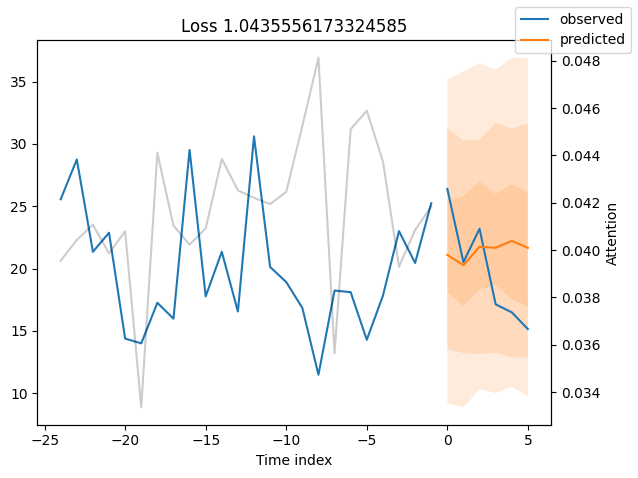

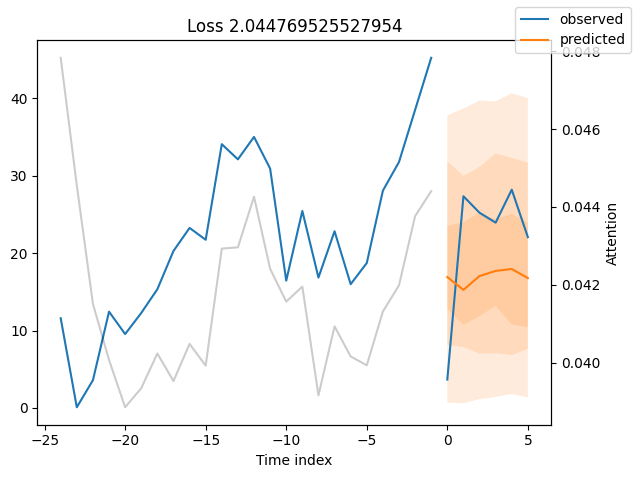

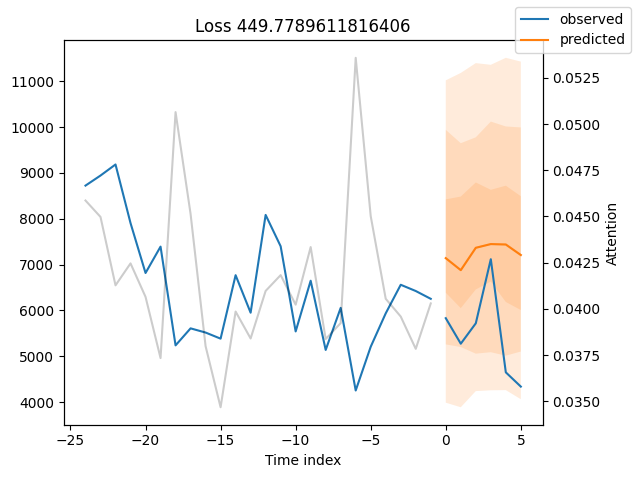

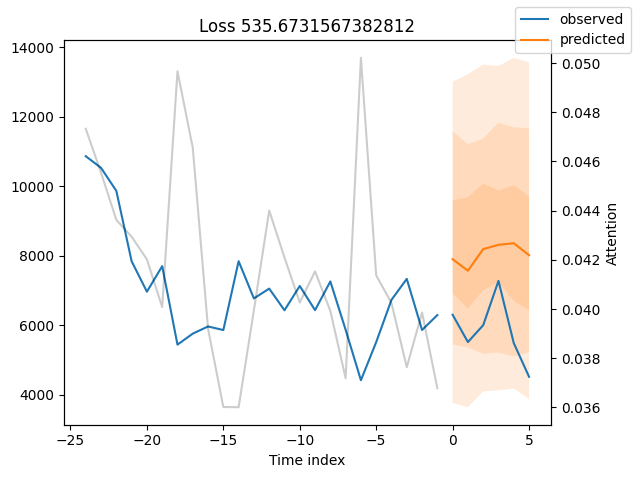

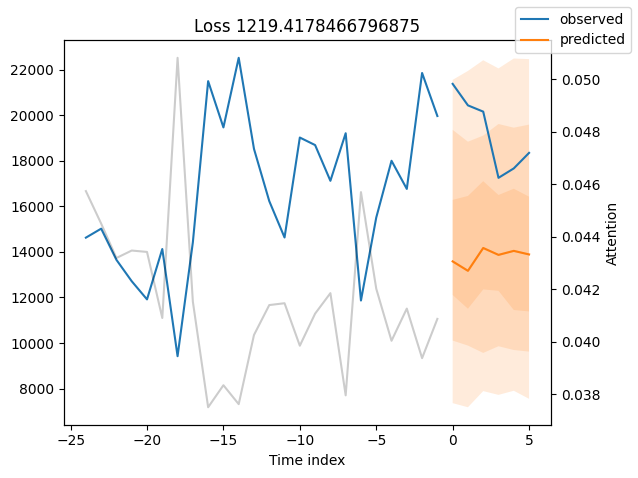

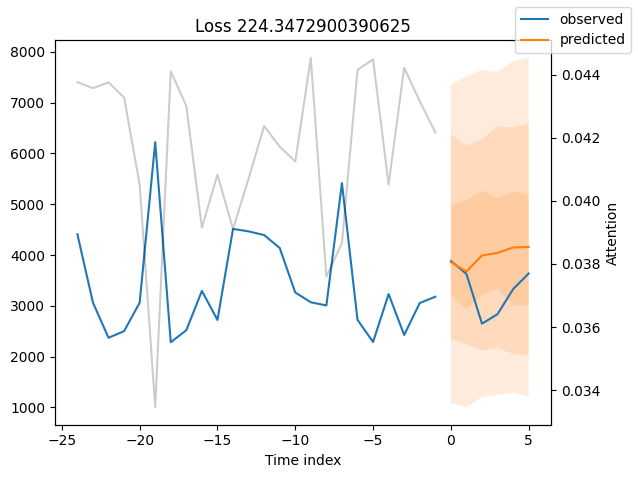

In [14]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

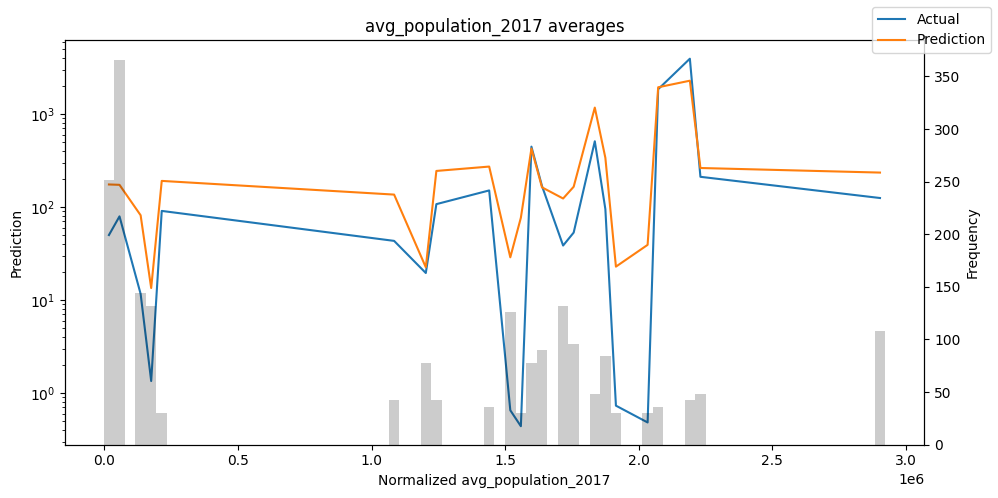

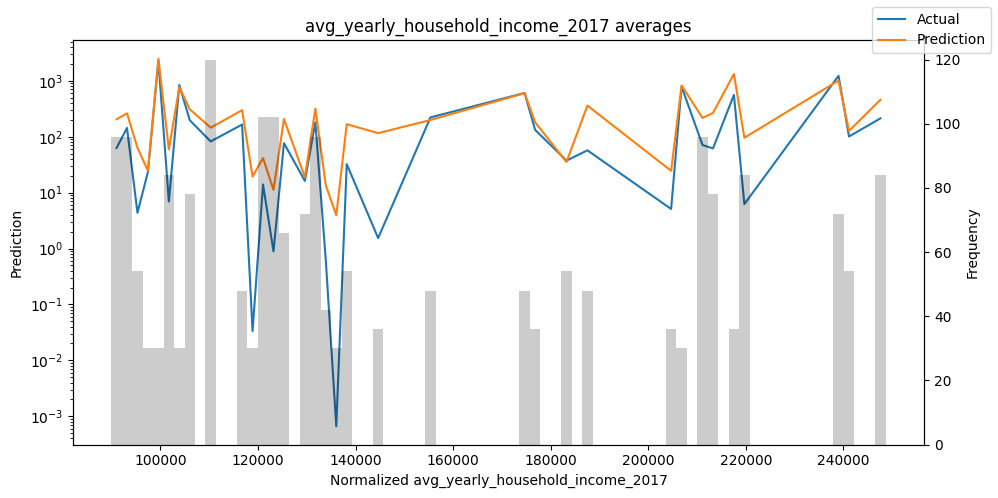

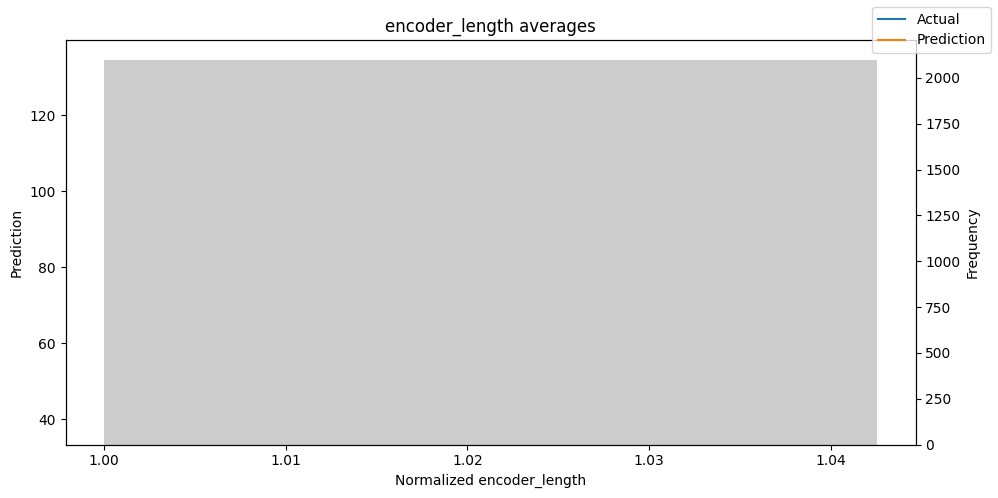

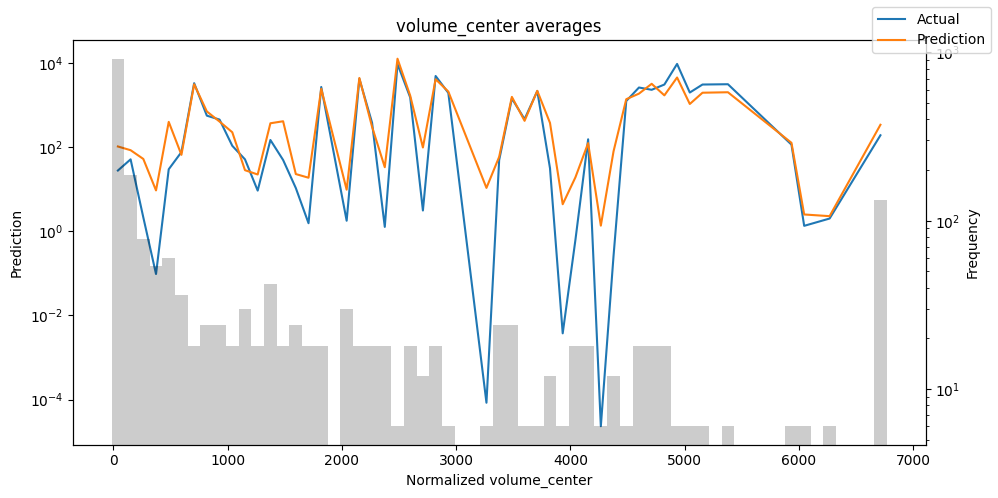

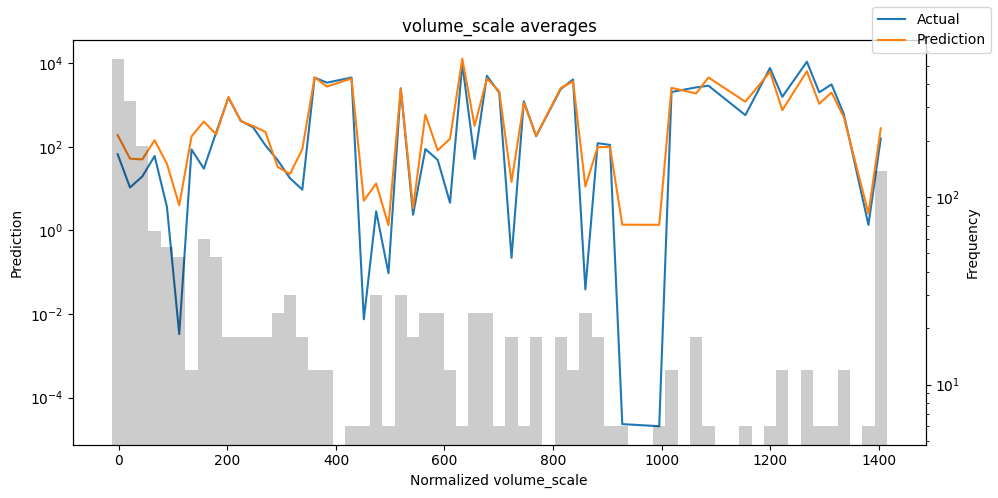

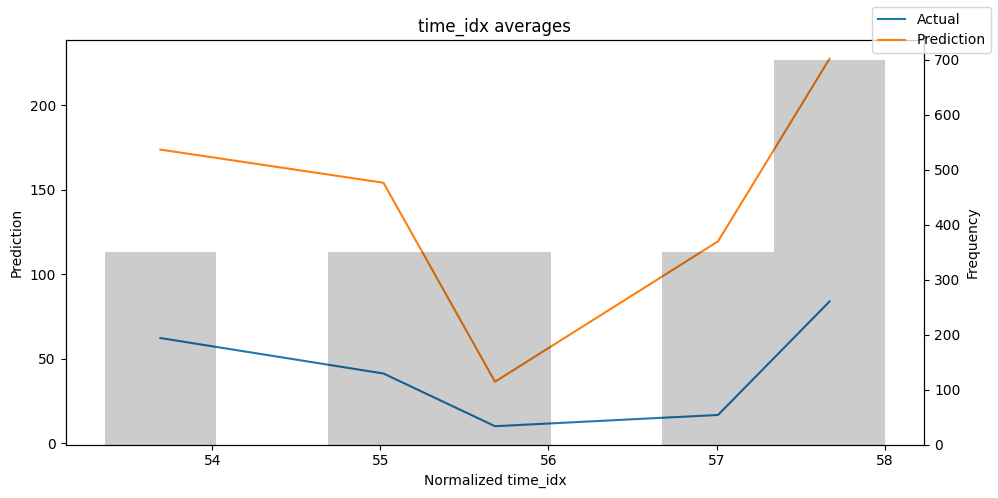

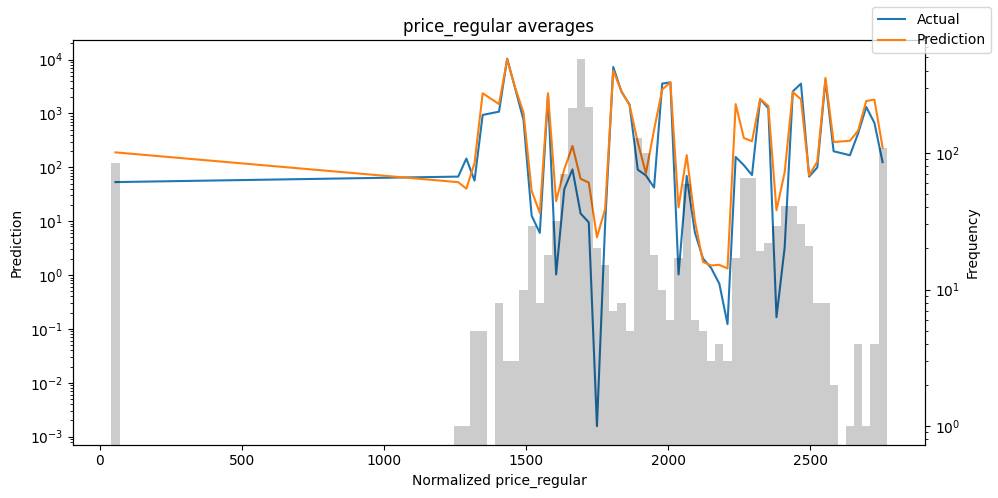

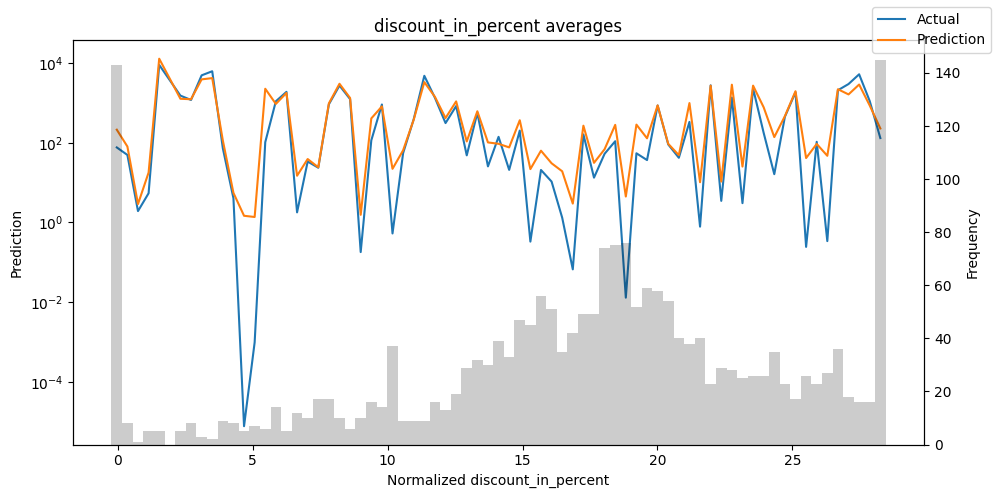

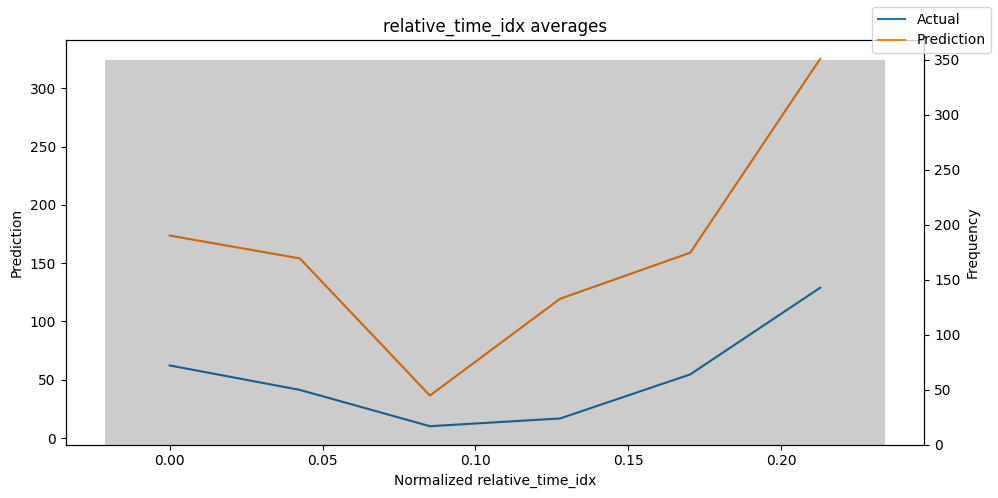

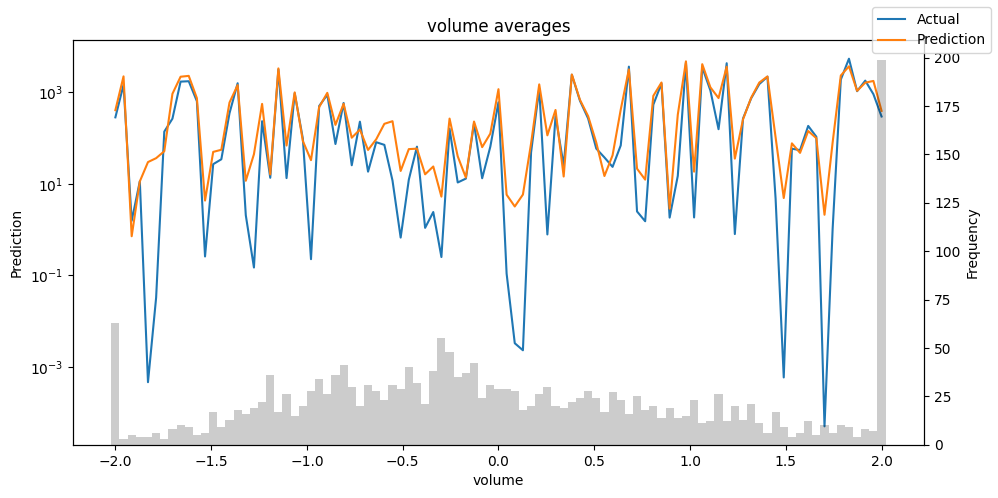

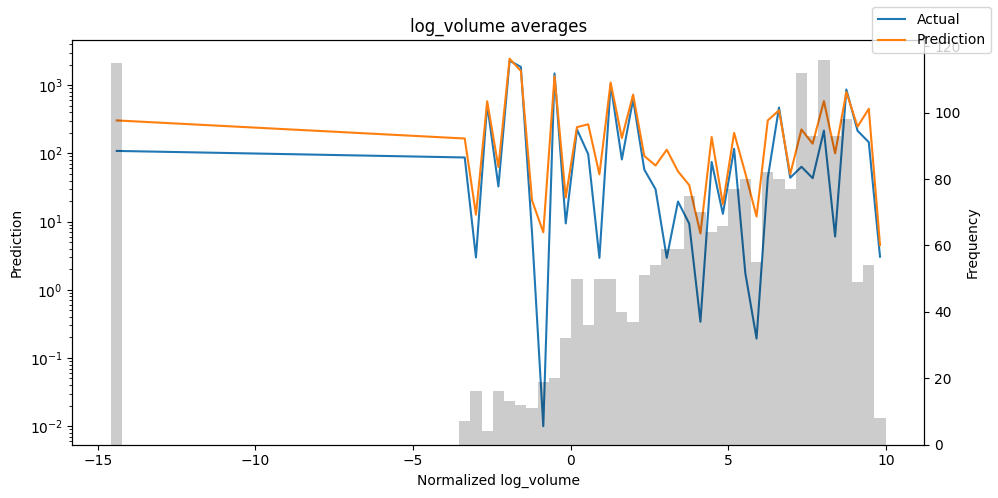

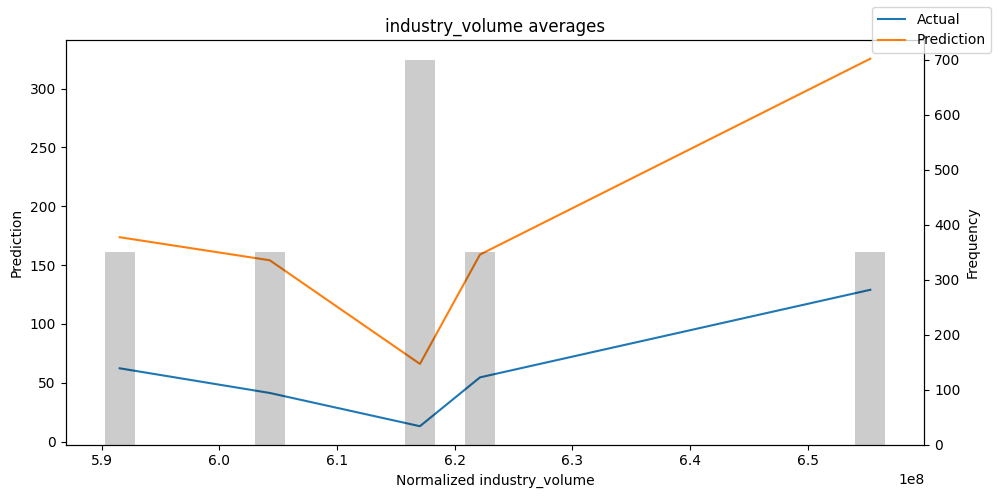

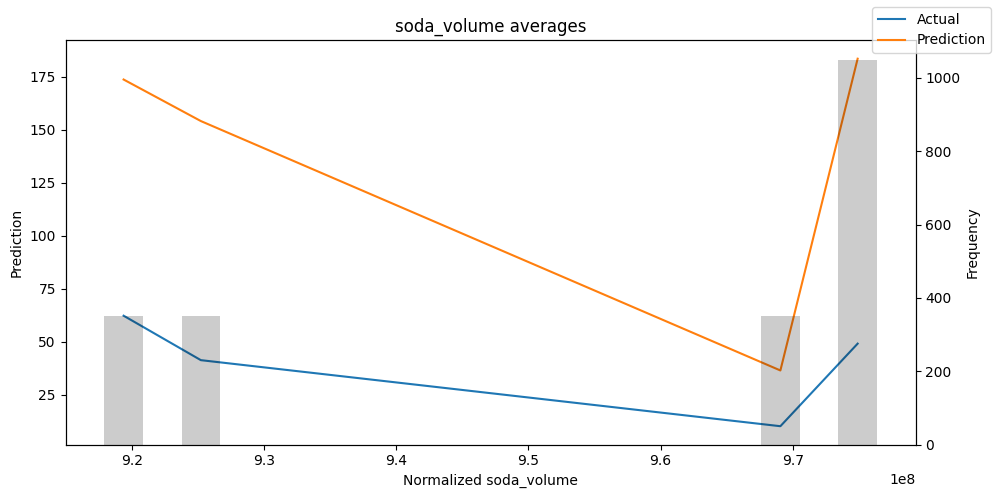

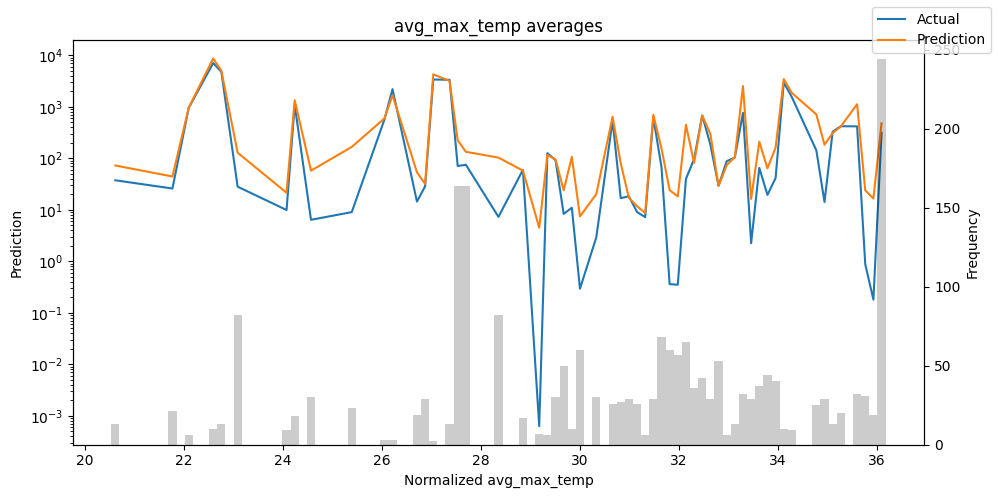

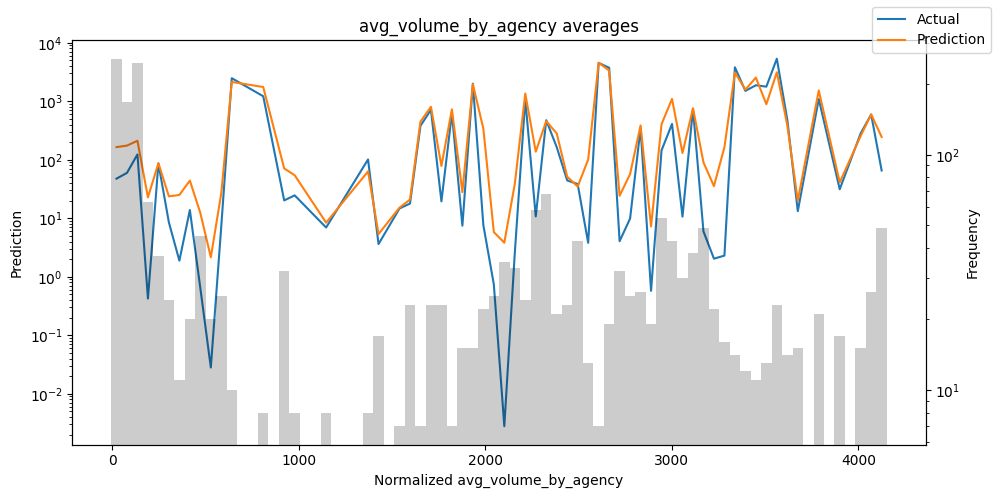

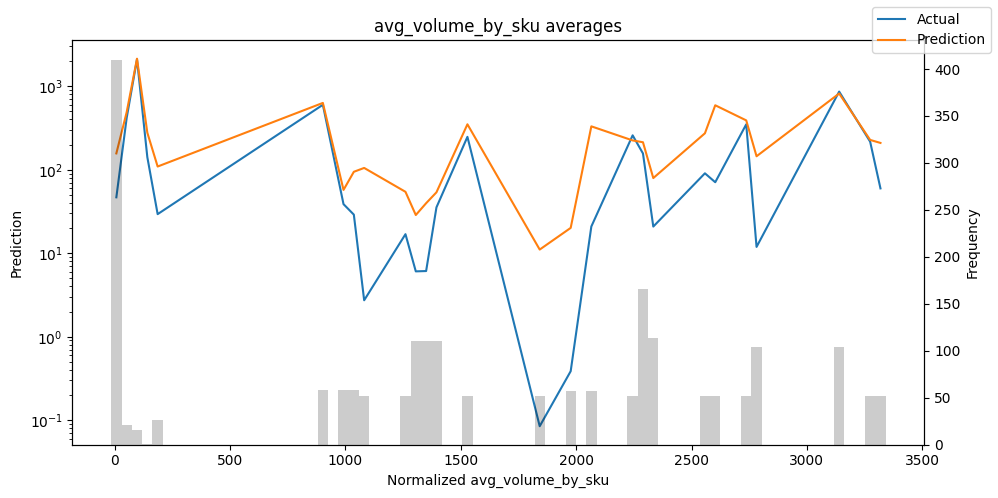

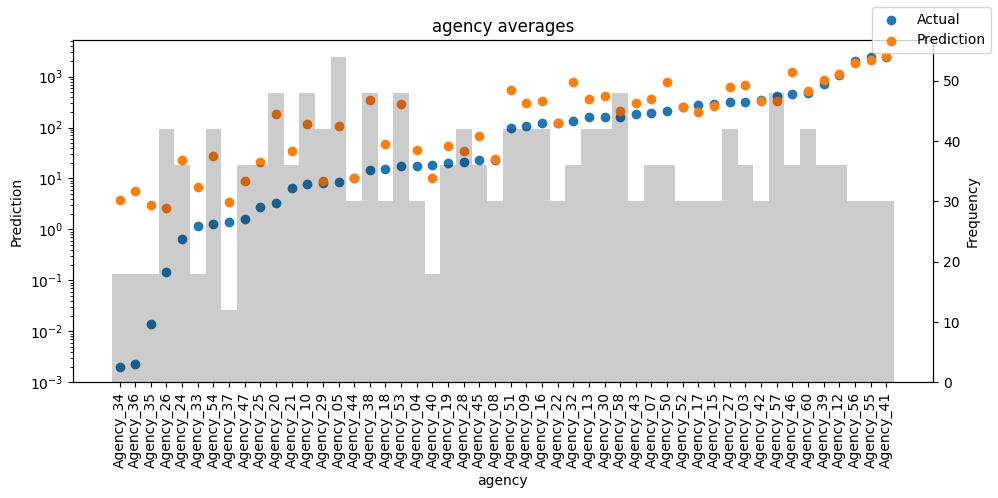

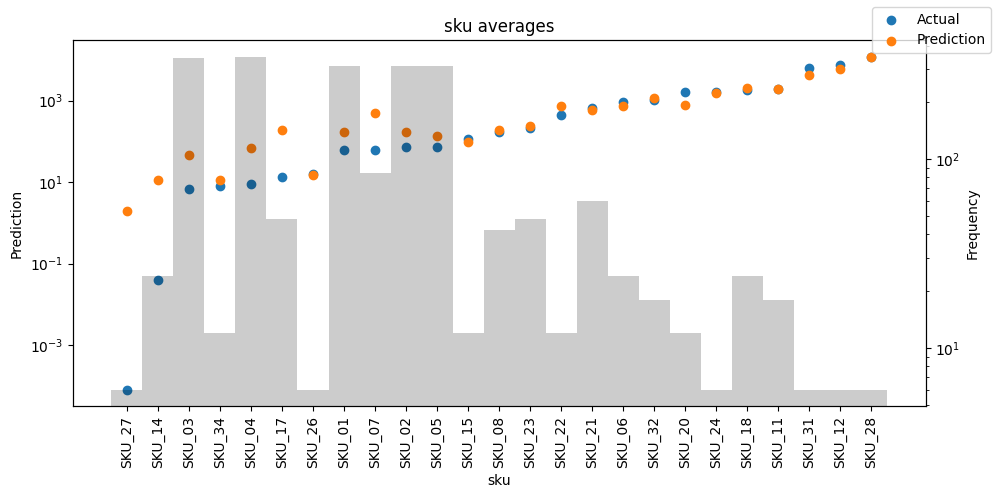

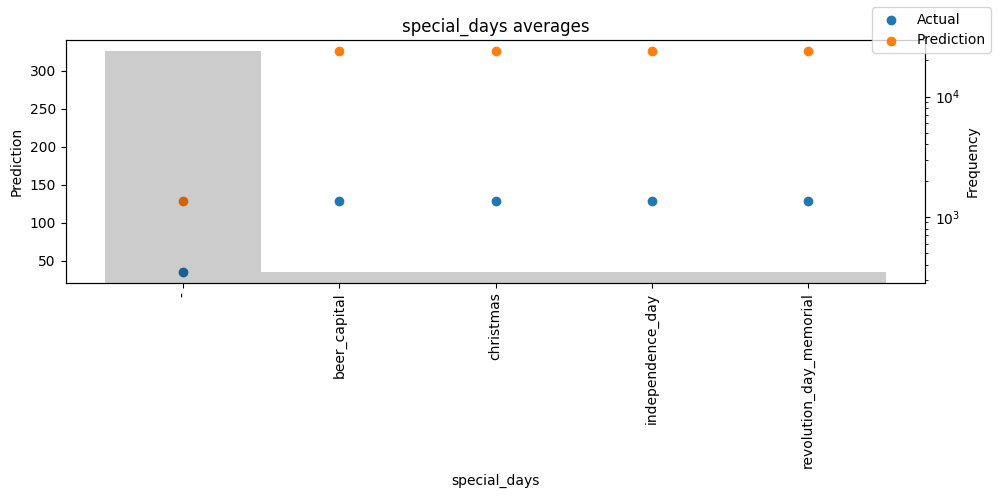

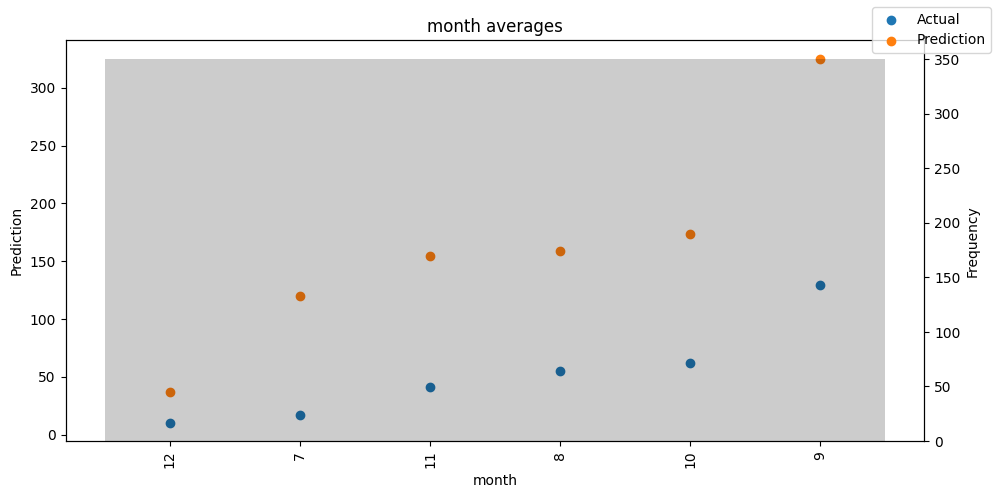

In [15]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [16]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

tensor([[[ 14.8360,  32.6627,  53.1622,  83.5156, 109.4014, 144.2540, 176.4734],
         [ 16.3019,  36.9118,  56.7892,  80.4736, 108.1578, 140.3861, 173.3806],
         [  8.8236,  30.9936,  54.1317,  79.0623, 108.4195, 142.8168, 175.4402],
         [ 10.9834,  39.9732,  59.2042,  80.1960, 102.8376, 140.4816, 163.3967],
         [  9.4672,  38.3123,  50.6210,  74.2993, 103.5287, 134.1687, 165.7299],
         [ 12.3726,  36.3803,  57.9775,  81.4235, 108.9473, 137.5943, 169.5935]]])

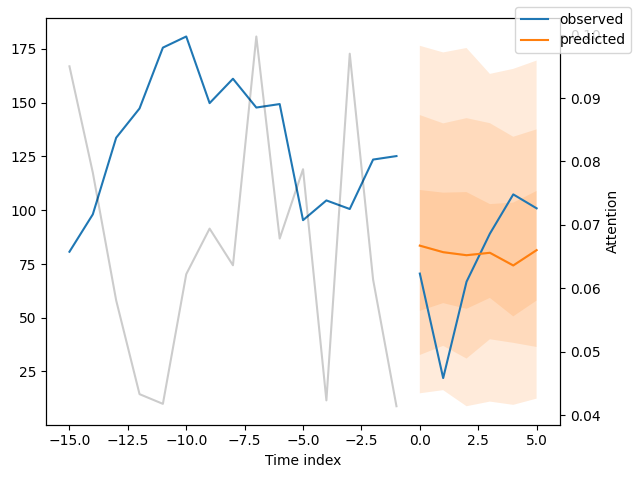

In [17]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0)

In [18]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

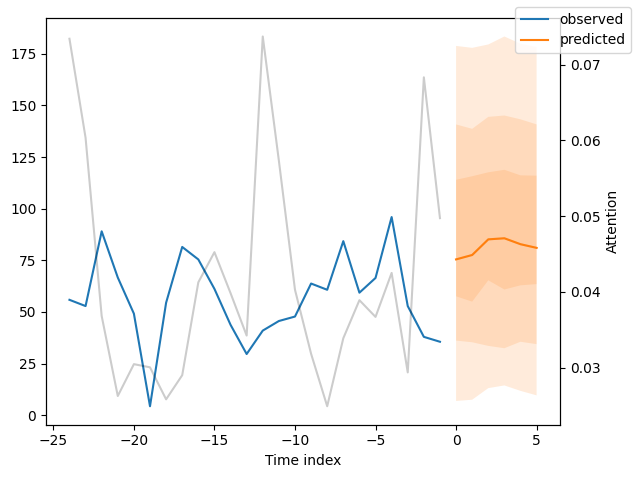

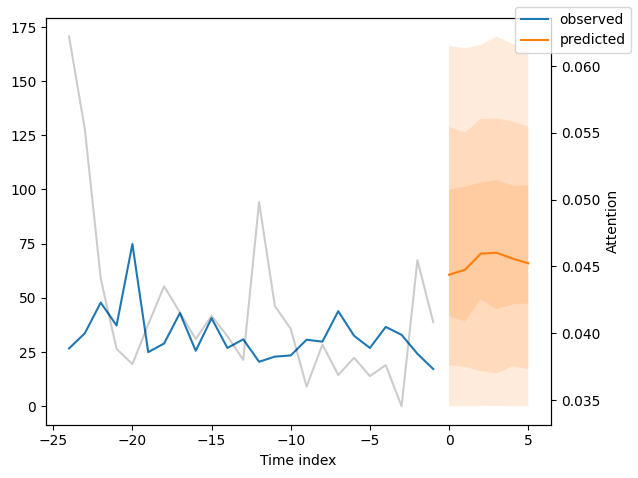

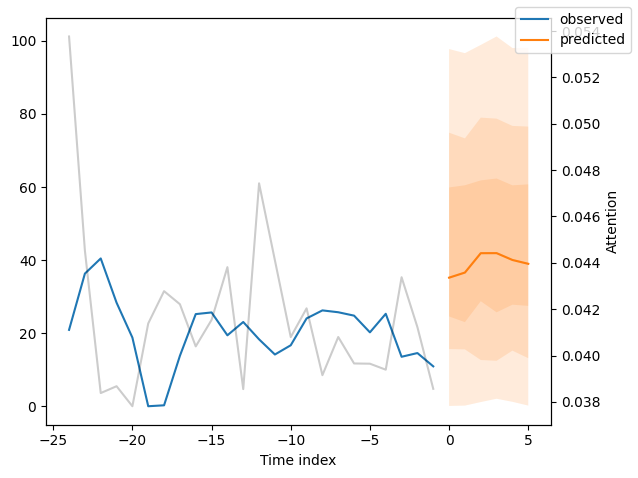

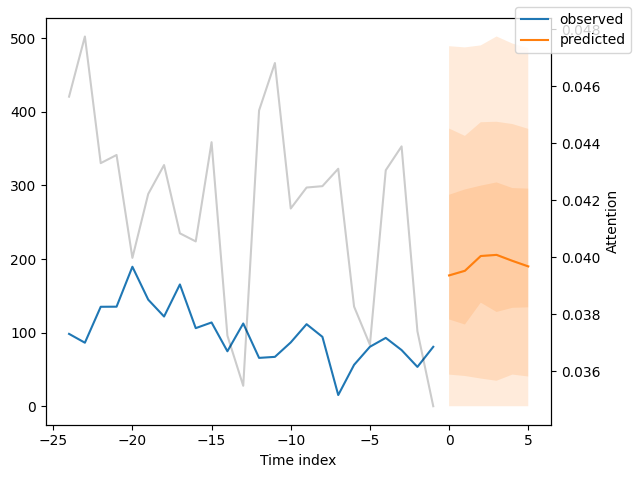

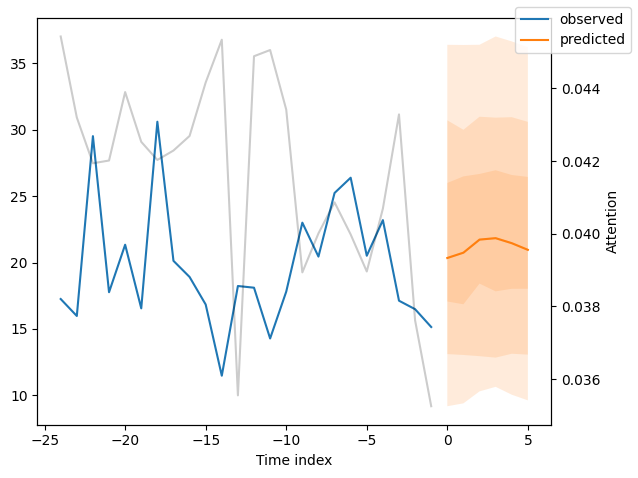

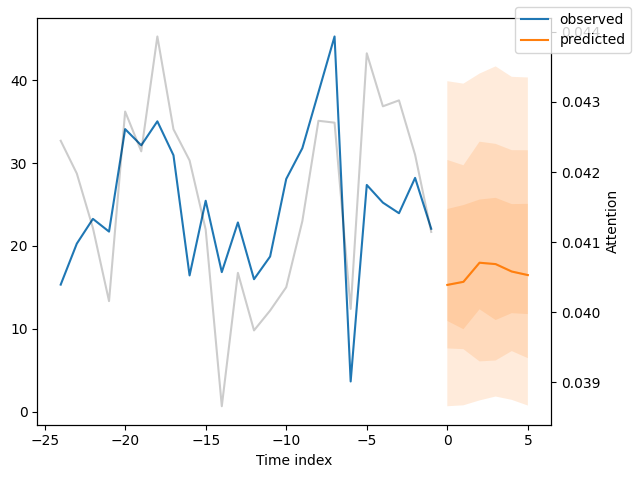

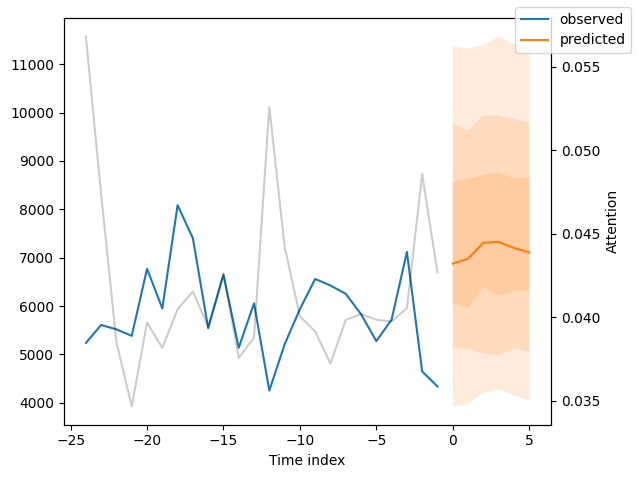

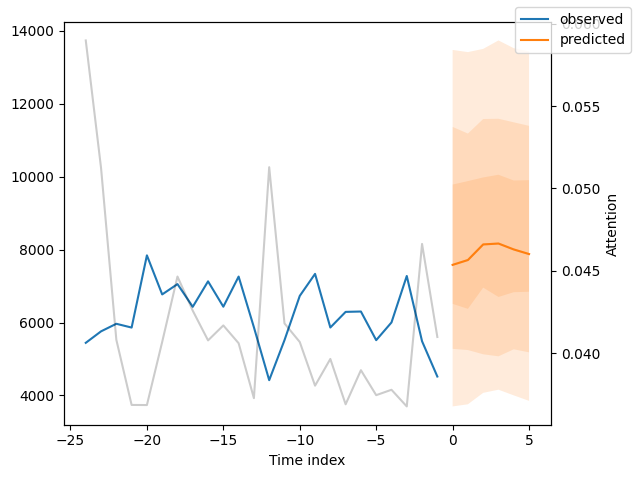

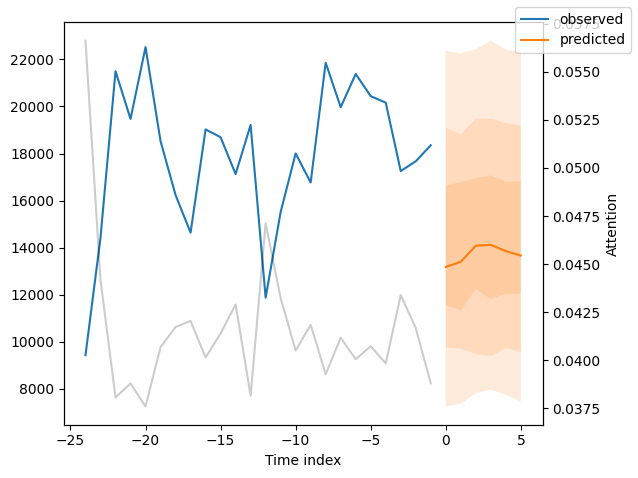

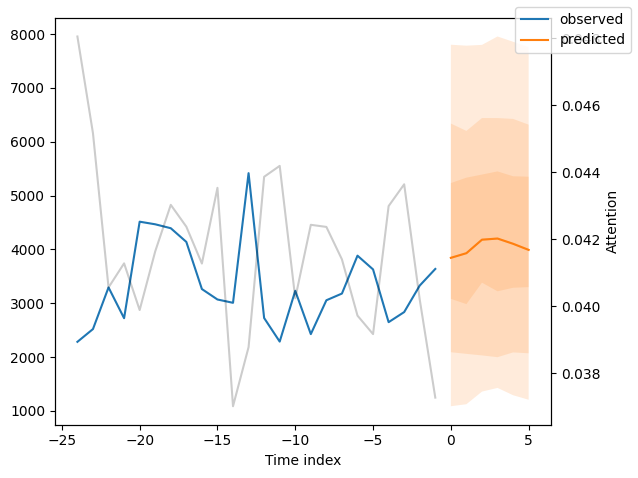

In [19]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x525 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

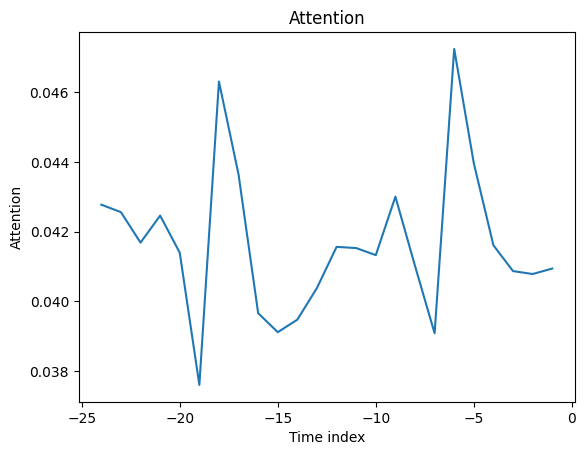

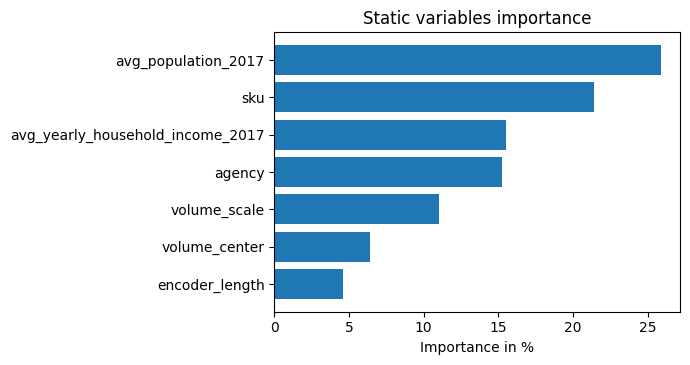

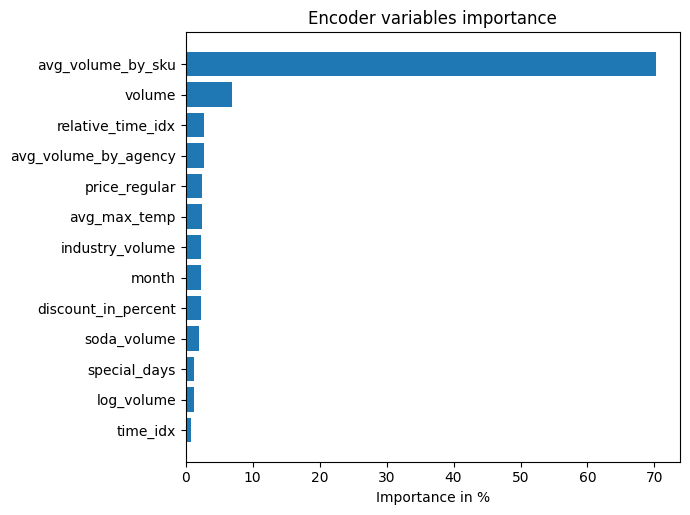

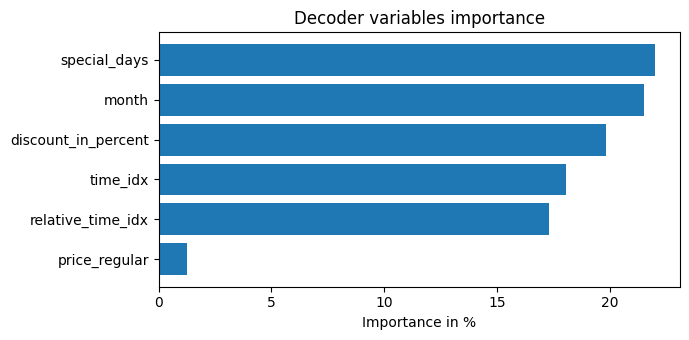

In [20]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [21]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict: 100%|██████████| 30/30 [00:08<00:00,  3.46 batches/s]


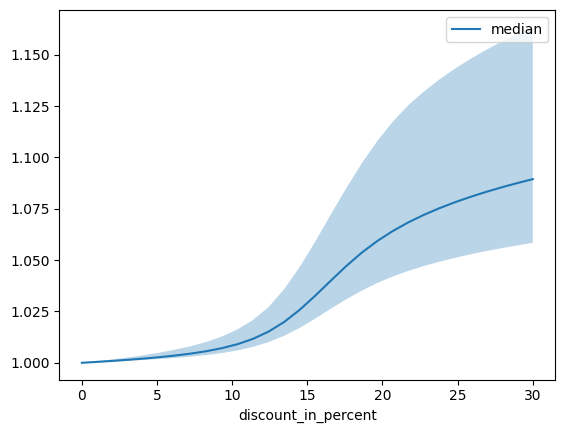

In [22]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)